# Notebook 11

## Solución numérica de EDO (parte 4)

#### Python 🐍

> Dr. Ricardo Méndez Fragoso $\mathbb{R} i \vec c \hbar$

### Biblioteca externa de integración y algunas aplicaciones

En este notebook utilizaremos bibliotecas externas especializadas en integración numérica de EDO. En el caso de Python, una de las mejores bibliotecas es `scipy.integrate`, y es la que utilizaremos en este notebook como se muestra a continuación:

In [1]:
from pylab import *
from scipy.integrate import *

Para mostrar el uso de este tipo de integradores, utilicemos el sistema de EDO's asociado al péndulo:

$$
\frac{d\theta}{dt} = v_{\theta} \\
\frac{d v_{\theta}}{dt} = -\omega_0 ^2 \sin \theta
$$

En el caso de la biblioteca de DifferentialEquations necesita que la función asociada a este sistema de EDO's sea de la siguiente forma:

In [2]:
def pendulo(x,t):
    dx1 = x[1]
    dx2 = -sin(x[0])
    return array([dx1,dx2])

Para que posteriormente podamos hacer comparaciones con nuestros integradores desarrollados en el notebook anterior, a continuación los ponemos en la siguiente celda:

In [3]:
def RK_2(edo,x_ini,t):
    sol = zeros( (len(t) , len(x_ini)) )
    sol[0,:] = x_ini
    delta = t[1]-t[0]
    for i in range(0,len(t)-1):
        k1 = sol[i,:] + 0.5*delta*edo(sol[i,:],t[i])
        sol[i+1,:] = sol[i,:] + delta*edo(k1,t[i]+0.5*delta)
    return sol

def RK_4(edo,x_ini,t):
    sol = zeros( (len(t) , len(x_ini)) )
    sol[0,:] = x_ini
    delta = t[1]-t[0]
    for i in range(0,len(t)-1):
        k1 = edo(sol[i,:],t[i])
        k2 = edo(sol[i,:] + 0.5*delta*k1 , t[i] + 0.5*delta)
        k3 = edo(sol[i,:] + 0.5*delta*k2 , t[i] + 0.5*delta)
        k4 = edo(sol[i,:] + delta*k2 , t[i] + delta)
        sol[i+1,:] = sol[i,:] + (delta/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
    return sol

Para comparar los datos con el notebook equivalente hecho en `Julia`, haremos los mismos pasos de integración que vienen en ese archivo. En la siguiente celda hacemos el proceso de integración numérica con cada uno de los integradores.

In [4]:
tiempo = linspace(0,2*pi,16)
p_ini = [1.0,0]
sol_RK2 = RK_2(pendulo,p_ini,tiempo)
sol_RK4 = RK_4(pendulo,p_ini,tiempo)
sol_ODEint = odeint(pendulo,p_ini,tiempo)

El formato de salida de todos los integradores es el mismo. A diferencia del notebook de `Julia` en este caso la salida de `ODEint` es un arreglo que podemos manipular y el usuario se tienen que encargar de todo lo que tiene que ver con interpolaciones o manejo de datos. En la siguiente gráfica se observa el resultado con cada uno de los integradores.

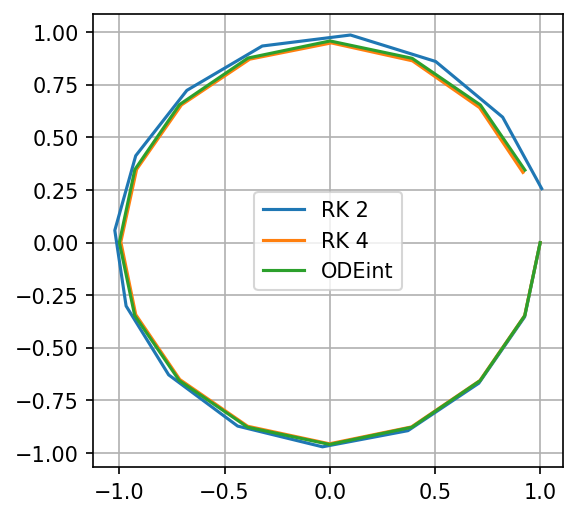

In [5]:
figure(dpi=150)
plot(sol_RK2[:,0],sol_RK2[:,1],label="RK 2")
plot(sol_RK4[:,0],sol_RK4[:,1],label="RK 4")
plot(sol_ODEint[:,0],sol_ODEint[:,1],label="ODEint")
grid(),legend(),gca().set_aspect("equal")
show()

Como se puede observar, en el caso de `RK_2` queda muy lejos de `RK_4` y `ODEint`, mientras que estos dos últimos quedan relativamente cercanos. Veamos el punto final de integración para observar las diferencias un poco más de cerca:

In [6]:
print("Con ODEint: \t",sol_ODEint[-1,0]," , ",sol_ODEint[-1,1])
print("Con RK_2: \t",sol_RK2[-1,0]," , ",sol_RK2[-1,1])
print("Con RK_4: \t",sol_RK4[-1,0]," , ",sol_RK4[-1,1])

Con ODEint: 	 0.9274948508544009  ,  0.3450736521706133
Con RK_2: 	 1.007413048950838  ,  0.25680492442441893
Con RK_4: 	 0.9180436827521471  ,  0.33411920097003617


### Líneas de campo de un dipolo

En el siguiente ejemplo vemos la forma de graficar las líneas de campo de un dipolo eléctrico. Este tiene la peculiaridad de que cuando nos acercamos a la carga el campo eléctrico crece infinitamente y ello hace que el integrador se vuelva inestable. Veamos este ejemplo más de cerca. 

El campo eléctrico de un dipolo está dado por la siguiente ecuación:

$$
\vec E = \frac{q}{4\pi \epsilon _0} \left( \frac{x\hat i +  y\hat j + (z-1)\hat k}{(x^2 + y^2 + (z-1)^2)^{3/2}} + \frac{x\hat i +  y\hat j + (z+1)\hat k}{(x^2 + y^2 + (z+1)^2)^{3/2}} \right)
$$

Este campo está descrito por la siguiente función:

In [7]:
def dipolo_odeint(x,t):
    r_up = ( x[0]**2 + x[1]**2 + (x[2]-1)**2 )**1.5
    r_dw = ( x[0]**2 + x[1]**2 + (x[2]+1)**2 )**1.5
    dx = x[0]*( 1.0/r_up - 1.0/r_dw )
    dy = x[1]*( 1.0/r_up - 1.0/r_dw )
    dz =  (x[2]-1.0)/r_up - (x[2]+1.0)/r_dw 
    return array([dx,dy,dz])

Al igual que en el caso anterior, podemos hacer la integración en algún punto cercano a la carga de arriba.

In [8]:
p_ini = [0.01,0.0,1.0]
t = linspace(0,8)
sol_odeint = odeint(dipolo_odeint,p_ini,t)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Como se puede apreciar, el integrador de `odeint` hace el trabajo, pero manda una advertencia de que está siendo forzado. Esto se debe a que el integrador se está acercando a la carga de abajo y ahí el campo diverge. Para solucionar esto, hay que utilizar otro integrador que nos permita introducir una condición en la que se advierta la rápida divergencia del campo eléctrico al momento de acercarse a la carga de abajo. Para ello utilizaremos [`solve_ivp`](https://docs.scipy.org/doc/scipy-1.5.4/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) que viene también dentro de la biblioteca de `scipy.integrate`. En este caso la función que representa al campo de un dipolo es:

> Nota: Para utilizar `solve_ivp` hay que intercambiar de lugar las variables `t` y `x` tanto en la función como en el integrador a diferencia de como se hace con `odeint`. 

In [9]:
def dipolo(t,x):
    r_up = ( x[0]**2 + x[1]**2 + (x[2]-1)**2 )**1.5
    r_dw = ( x[0]**2 + x[1]**2 + (x[2]+1)**2 )**1.5
    dx = x[0]*( 1.0/r_up - 1.0/r_dw )
    dy = x[1]*( 1.0/r_up - 1.0/r_dw )
    dz =  (x[2]-1.0)/r_up - (x[2]+1.0)/r_dw 
    return array([dx,dy,dz])

Para encontrar la solución procedemos como con el integrador anterior, pero especificamos el tiempo de integración como una tupla:

In [10]:
p_ini = [0.01,0.0,1.0]
t = (0,8)
sol = solve_ivp(dipolo,t,p_ini)
sol

  message: 'Required step size is less than spacing between numbers.'
     nfev: 980
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 1.23731397e-06, 2.38135220e-06, 8.67107982e-06,
       1.68277469e-05, 7.72114287e-05, 1.33970547e-04, 4.44002134e-04,
       8.46418993e-04, 3.78493550e-03, 6.56580893e-03, 2.20675593e-02,
       4.16887260e-02, 1.38470671e-01, 2.63298047e-01, 6.82700879e-01,
       1.39657725e+00, 2.79861095e+00, 4.89127997e+00, 6.24756534e+00,
       6.64848588e+00, 7.04940641e+00, 7.20267633e+00, 7.24899849e+00,
       7.29532065e+00, 7.32649962e+00, 7.33042691e+00, 7.33163650e+00,
       7.33284609e+00, 7.33366556e+00, 7.33381369e+00, 7.33387599e+00,
       7.33388385e+00, 7.33388628e+00, 7.33388872e+00, 7.33389023e+00,
       7.33389054e+00, 7.33389071e+00, 7.33389074e+00, 7.33389076e+00,
       7.33389077e+00, 7.33389077e+00, 7.33389078e+00, 7.33389078e+00,
       7.33389078e+00, 7.33389078e+00, 7.33389078e

Como se puede apreciar, la salida del integrador tiene muchos más datos, en particular nos está diciendo de no tuvo éxito al momento de resolver el problema por la misma razón que con el integrador anterior. Para solucionar esto, podemos programar una función que nos represente la región en la que si debemos hacer la integración. En este caso dicha función es `condicion()` y le podemos poner el atributo:
```python
condicion.terminal = True
```
con la finalidad de que se pueda utilizar con el integrador.

In [11]:
def condicion(t,x):
    return sqrt(x[0]**2 + x[1]**2 + (x[2]+1)**2) > 0.01
condicion.terminal = True

De esta manera podemos comenzar con la integración. Además agregaremos la opción `dense_output=True` que nos permite utilizar interpolaciones al momento de realizar gráficas.

In [12]:
p_ini = [0.01,0.0,1.0]
t = (0.0,8.0)
sol_ODEivp = solve_ivp(dipolo,t,p_ini,events=condicion,dense_output=True)
sol_ODEivp

  message: 'A termination event occurred.'
     nfev: 338
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7faed67941d0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.23731397e-06, 2.38135220e-06, 8.67107982e-06,
       1.68277469e-05, 7.72114287e-05, 1.33970547e-04, 4.44002134e-04,
       8.46418993e-04, 3.78493550e-03, 6.56580893e-03, 2.20675593e-02,
       4.16887260e-02, 1.38470671e-01, 2.63298047e-01, 6.82700879e-01,
       1.39657725e+00, 2.79861095e+00, 4.89127997e+00, 6.24756534e+00,
       6.64848588e+00, 7.04940641e+00, 7.20267633e+00, 7.24899849e+00,
       7.29532065e+00, 7.32649962e+00, 7.33042691e+00, 7.33163650e+00,
       7.33284609e+00, 7.33366556e+00, 7.33381369e+00, 7.33387599e+00,
       7.33388385e+00, 7.33388628e+00, 7.33388872e+00, 7.33389023e+00,
       7.33389054e+00])
 t_events: [array([7.33389054])]
        y: array([[ 0.01      ,  0.01637097,  0.01984831,  0.02972198,  0.03701634,
         0.0601371

Como se puede observar, el status de salida ahora es 1 y el integrador dice que el proceso ha sido satisfactorio. Finalmente utilizamos una variable `t_cont` con un `linspace()` para hacer una interpolación al momento de hacer la gráfica y la línea de campo se vea continua.

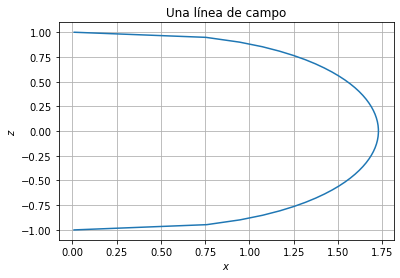

In [13]:
t_cont = linspace(0,sol_ODEivp.t[-1])
plot(sol_ODEivp.sol(t_cont)[0,:],sol_ODEivp.sol(t_cont)[2,:])
grid(),title("Una línea de campo"),xlabel(r"$x$"),ylabel(r"$z$")
show()

Una vez que estamos seguros de como hacer el proceso de integración, podemos hacer varias líneas de campo para representar al dipolo.

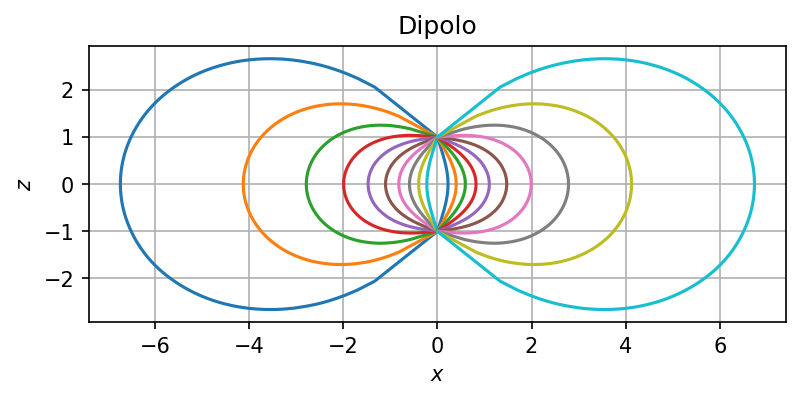

In [14]:
figure(dpi=150)
angulos = linspace(-2*pi/5,pi/4,10)
angulos = concatenate((23*pi/20+angulos,angulos))
for angulo in angulos:
    p_ini = [0.01*cos(angulo),0.0,1+0.01*sin(angulo)]
    t = (0,1000)
    sol_ODEivp = solve_ivp(dipolo,t,p_ini,events=condicion,dense_output=True)
    t_cont = linspace(0,sol_ODEivp.t[-1],500)
    plot(sol_ODEivp.sol(t_cont)[0,:],sol_ODEivp.sol(t_cont)[2,:])
grid(),title("Dipolo"),gca().set_aspect("equal"),xlabel(r"$x$"),ylabel(r"$z$")
show()

Como se puede observar la biblioteca de `scipy.integrate` es muy poderosa y se invita al lector a ver el [manual de operación](https://docs.scipy.org/doc/scipy/reference/integrate.html), el cual es bastante extenso, para ver las diferentes opciones que ofrece. Cabe mencionar que como en toda tarea computacional, es importante seleccionar los algoritmos adecuados a utilizar, ya que se tienen que tener en cuenta precisión y tiempos de ejecución.

[Regresar a la página del curso.](http://sistemas.fciencias.unam.mx/~rich/FisComp/)

Se agradece el apoyo del proyecto DGAPA-PAPIME:

+ PE 103021 nueva versión durante el año 2022. Versión interactiva en Colab.
+ PE 112919 durante el año 2020. Idea original.